# Dự báo 100 ngày giá đóng cửa FPT bằng LTSF-Linear

## Phạm vi quy trình
- Làm sạch và khám phá dữ liệu trong `FPT_train.csv`
- Tạo đặc trưng log-price, chuẩn hóa theo chuẩn thời gian để tránh leakage
- Huấn luyện các mô hình Linear, DLinear, NLinear với các độ dài chuỗi 7/30/120/480 ngày
- Dự báo 100 ngày tiếp theo, đối chiếu kết quả và xuất file submission (101 dòng gồm header `id,close`)

## 1. Import thư viện và đọc dữ liệu

In [1]:
# Placeholder for optional download helpers (không dùng trong notebook này)

In [2]:
import os
import warnings
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
df = pd.read_csv('FPT_train.csv')
print(f"FPT dataset shape: {df.shape}")
print(f"Date range: {df['time'].min()} → {df['time'].max()}")

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print("\nMẫu dữ liệu đầu tiên:")
display(df.head())

print("\nKiểu dữ liệu:")
print(df.dtypes)

print("\nThống kê cơ bản:")
display(df.describe())

FPT dataset shape: (1149, 7)
Date range: 2020-08-03 → 2025-03-10

Mẫu dữ liệu đầu tiên:


,time,open,high,low,close,volume,symbol
0,2020-08-03,19.07,19.63,19.03,19.63,1392200,FPT
1,2020-08-04,19.89,20.01,19.76,19.91,1051310,FPT
2,2020-08-05,19.89,20.16,19.78,20.10,1328520,FPT
3,2020-08-06,20.10,20.21,19.97,20.01,1153660,FPT
4,2020-08-07,20.01,20.44,20.01,20.14,1283690,FPT



Kiểu dữ liệu:
time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
symbol            object
dtype: object

Thống kê cơ bản:


,time,open,high,low,close,volume
count,1149,1149.000000,1149.000000,1149.000000,1149.000000,1.149000e+03
mean,2022-11-18 03:30:32.898172416,61.965666,62.625483,61.349721,61.999182,2.444857e+06
min,2020-08-03 00:00:00,19.070000,19.630000,19.030000,19.630000,2.219660e+05
25%,2021-09-24 00:00:00,46.690000,47.180000,46.110000,46.640000,1.244928e+06
50%,2022-11-16 00:00:00,51.340000,51.860000,50.890000,51.290000,1.984701e+06
75%,2024-01-09 00:00:00,71.730000,72.470000,71.060000,71.580000,3.062690e+06
max,2025-03-10 00:00:00,132.870000,134.500000,132.260000,133.040000,1.372370e+07
std,NaN,29.457209,29.700736,29.221866,29.462158,1.821708e+06


## 2. Khám phá dữ liệu & đặc trưng log-price

In [4]:
# Tạo thêm đặc trưng cơ bản
df['daily_return'] = df['close'].pct_change()
df['close_log'] = np.log(df['close'])
print("Đã thêm cột daily_return & close_log")

missing_info = df.isnull().sum()
print("\nMissing values per column:")
print(missing_info)

Đã thêm cột daily_return & close_log

Missing values per column:
time            0
open            0
high            0
low             0
close           0
volume          0
symbol          0
daily_return    1
close_log       0
dtype: int64


In [5]:
# Xử lý missing values và chuẩn hóa theo train split
df['daily_return'] = df['daily_return'].fillna(0)
df['close_log'] = df['close_log'].fillna(method='ffill')
df['close_log'] = df['close_log'].fillna(method='bfill')

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1 - train_ratio - val_ratio

train_cutoff = int(len(df) * train_ratio)
log_scaler = StandardScaler()
log_scaler.fit(df['close_log'].values[:train_cutoff].reshape(-1, 1))
df['close_log_scaled'] = log_scaler.transform(df['close_log'].values.reshape(-1, 1)).flatten()

print(f"Fit scaler trên {train_cutoff} quan sát đầu tiên (70% thời gian đầu)")
print(df[['time', 'close', 'close_log', 'close_log_scaled']].head())

Fit scaler trên 804 quan sát đầu tiên (70% thời gian đầu)
        time  close  close_log  close_log_scaled
0 2020-08-03  19.63   2.977059         -2.559053
1 2020-08-04  19.91   2.991222         -2.513731
2 2020-08-05  20.10   3.000720         -2.483339
3 2020-08-06  20.01   2.996232         -2.497699
4 2020-08-07  20.14   3.002708         -2.476977


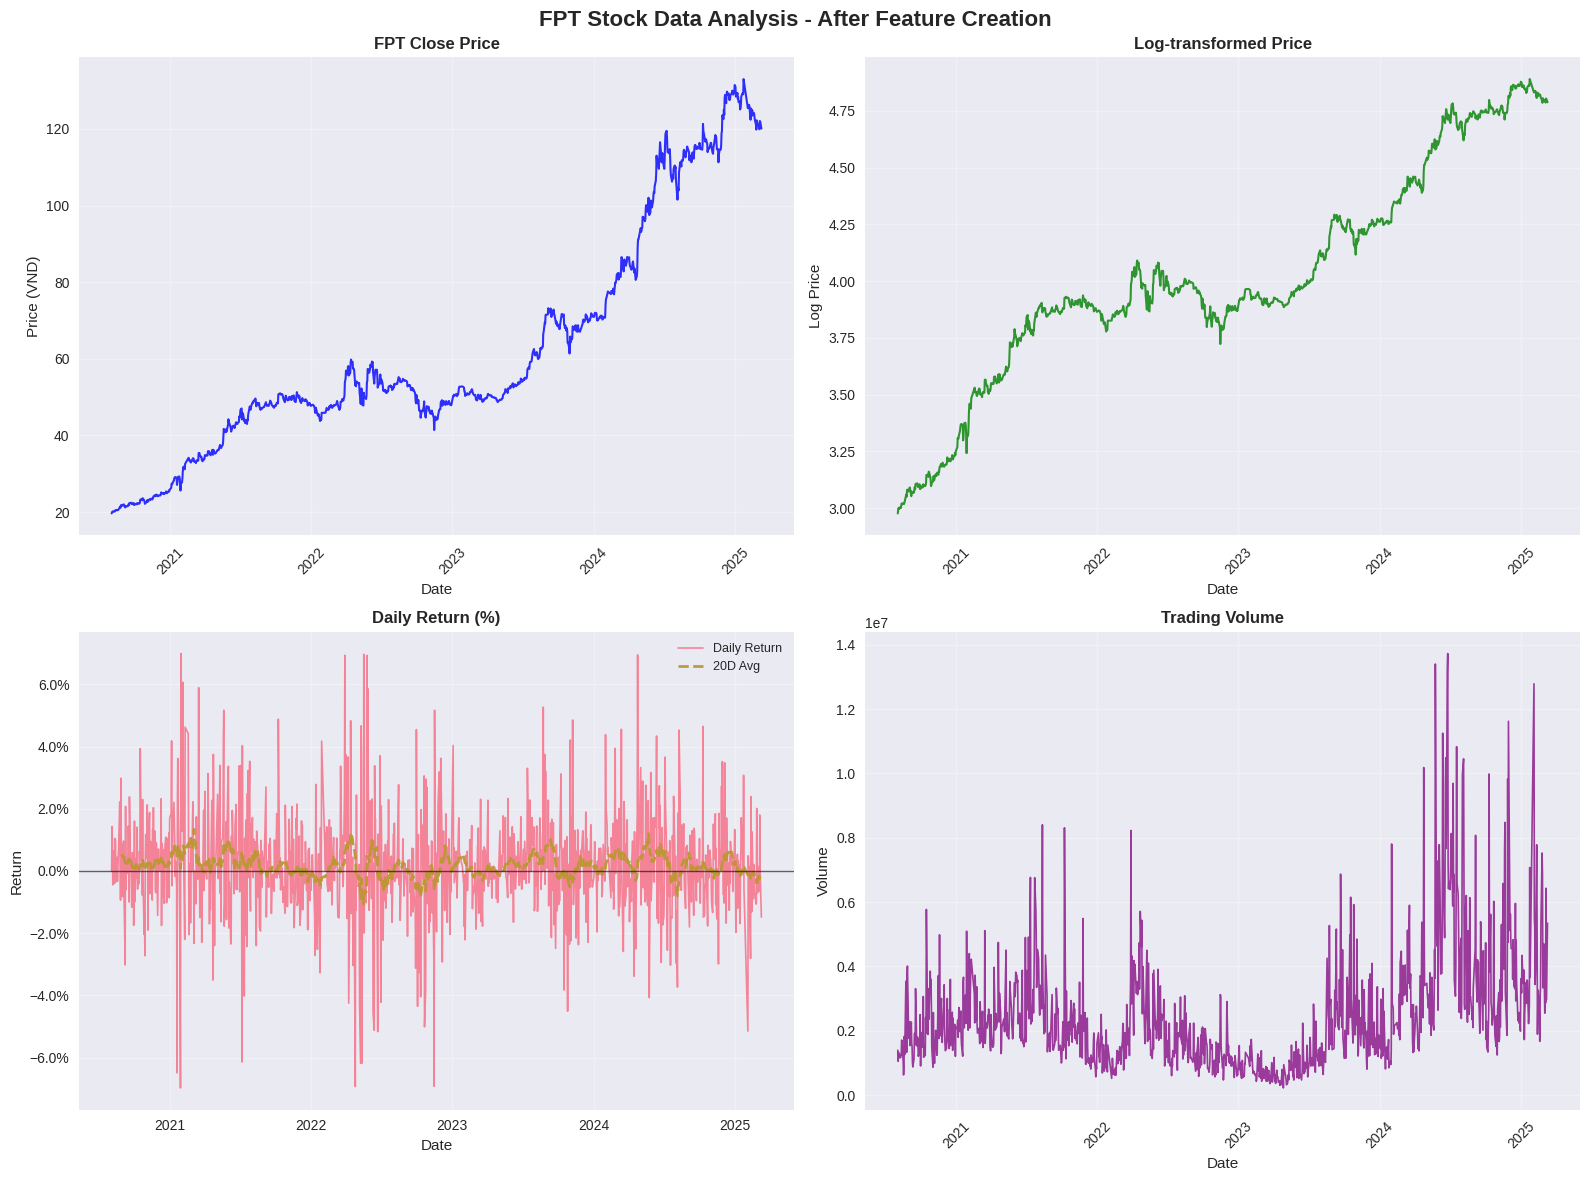

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('FPT Stock Data Analysis - After Feature Creation', fontsize=16, fontweight='bold')

axes[0, 0].plot(df['time'], df['close'], linewidth=1.5, color='blue', alpha=0.8)
axes[0, 0].set_title('FPT Close Price', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (VND)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].plot(df['time'], df['close_log'], linewidth=1.5, color='green', alpha=0.8)
axes[0, 1].set_title('Log-transformed Price', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Log Price')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

ret_ts = df[['time', 'daily_return']].dropna().copy()
ret_ts['ret_ma20'] = ret_ts['daily_return'].rolling(20).mean()
axes[1, 0].plot(ret_ts['time'], ret_ts['daily_return'], linewidth=1.2, alpha=0.85, label='Daily Return')
axes[1, 0].plot(ret_ts['time'], ret_ts['ret_ma20'], linewidth=2.0, linestyle='--', alpha=0.95, label='20D Avg')
axes[1, 0].axhline(0, color='black', linewidth=1, alpha=0.6)
axes[1, 0].set_title('Daily Return (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Return')
axes[1, 0].yaxis.set_major_formatter(PercentFormatter(1.0))
axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1, 0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=9)

axes[1, 1].plot(df['time'], df['volume'], linewidth=1.2, color='purple', alpha=0.75)
axes[1, 1].set_title('Trading Volume', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volume')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Chuẩn bị dataset chuỗi thời gian cho dự báo 100 ngày

In [7]:
class SlidingWindowDataset(Dataset):
    """Dataset trượt cho dự báo univariate"""
    def __init__(self, series, seq_len, pred_len):
        self.series = series.astype(np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.length = max(0, len(self.series) - self.seq_len - self.pred_len + 1)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.series[idx: idx + self.seq_len]
        y = self.series[idx + self.seq_len: idx + self.seq_len + self.pred_len]
        return torch.from_numpy(x), torch.from_numpy(y)

seq_lengths = {'7d': 7, '30d': 30, '120d': 120, '480d': 480}
pred_len = 100
series_scaled = df['close_log_scaled'].values

datasets = {}
for name, seq_len in seq_lengths.items():
    dataset = SlidingWindowDataset(series_scaled, seq_len, pred_len)
    datasets[name] = dataset
    print(f"{name}: seq_len={seq_len}, samples={len(dataset)}")
print(f"Pred horizon: {pred_len} ngày")

7d: seq_len=7, samples=1043
30d: seq_len=30, samples=1020
120d: seq_len=120, samples=930
480d: seq_len=480, samples=570
Pred horizon: 100 ngày


In [8]:
def create_time_based_splits(dataset):
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    test_len = total_len - train_len - val_len

    train_idx = list(range(0, train_len))
    val_idx = list(range(train_len, train_len + val_len))
    test_idx = list(range(train_len + val_len, total_len))

    return {
        'train': torch.utils.data.Subset(dataset, train_idx),
        'val': torch.utils.data.Subset(dataset, val_idx),
        'test': torch.utils.data.Subset(dataset, test_idx)
    }

data_splits = {name: create_time_based_splits(ds) for name, ds in datasets.items()}

for name, splits in data_splits.items():
    sizes = {split: len(subset) for split, subset in splits.items()}
    print(f"{name} → train {sizes['train']}, val {sizes['val']}, test {sizes['test']}")

7d → train 730, val 156, test 157
30d → train 714, val 153, test 153
120d → train 651, val 139, test 140
480d → train 399, val 85, test 86


# 4. Cài đặt mô hình LTSF-Linear cho dự báo 100 ngày

## 4.1 Định nghĩa Linear / DLinear / NLinear

In [9]:
class Linear(nn.Module):
    def __init__(self, seq_len, pred_len):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        return self.linear(x)

class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len, moving_avg=25):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.moving_avg = max(2, min(moving_avg, seq_len - 1))
        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)
        self.register_buffer('avg_kernel', torch.ones(1, 1, self.moving_avg) / self.moving_avg)

    def decompose(self, x):
        batch_size, seq_len = x.shape
        x_reshaped = x.unsqueeze(1)
        padding = self.moving_avg // 2
        x_padded = torch.nn.functional.pad(x_reshaped, (padding, padding), mode='replicate')
        trend = torch.nn.functional.conv1d(x_padded, self.avg_kernel, padding=0).squeeze(1)
        if trend.shape[1] != seq_len:
            trend = torch.nn.functional.interpolate(trend.unsqueeze(1), size=seq_len, mode='linear', align_corners=False).squeeze(1)
        seasonal = x - trend
        return trend, seasonal

    def forward(self, x):
        trend, seasonal = self.decompose(x)
        return self.linear_trend(trend) + self.linear_seasonal(seasonal)

class NLinear(nn.Module):
    def __init__(self, seq_len, pred_len):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        last = x[:, -1:].detach()
        normalized = x - last
        return self.linear(normalized) + last

model_factories = {
    'Linear': Linear,
    'DLinear': DLinear,
    'NLinear': NLinear
}
print("Đã khởi tạo factory cho Linear/DLinear/NLinear")

Đã khởi tạo factory cho Linear/DLinear/NLinear


## 5. Huấn luyện với early stopping (1000 epochs tối đa)

In [10]:
def make_loader(subset, batch_size, shuffle=False):
    if subset is None or len(subset) == 0:
        return None
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

def evaluate_model(model, loader, scaler, pred_len, device='cpu'):
    if loader is None or len(loader.dataset) == 0:
        return {'mse': np.nan, 'mae': np.nan, 'rmse': np.nan, 'r2': np.nan,
                'pred_sequences_log': np.array([]), 'actual_sequences_log': np.array([]),
                'pred_sequences_price': np.array([]), 'actual_sequences_price': np.array([])}

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            preds.append(outputs.cpu().numpy())
            trues.append(batch_y.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)

    preds_log = scaler.inverse_transform(preds.reshape(-1, 1)).reshape(-1, pred_len)
    trues_log = scaler.inverse_transform(trues.reshape(-1, 1)).reshape(-1, pred_len)
    preds_price = np.exp(preds_log)
    trues_price = np.exp(trues_log)

    mse = mean_squared_error(trues_price.flatten(), preds_price.flatten())
    mae = mean_absolute_error(trues_price.flatten(), preds_price.flatten())
    rmse = np.sqrt(mse)
    try:
        r2 = r2_score(trues_price.flatten(), preds_price.flatten())
    except ValueError:
        r2 = np.nan

    return {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'pred_sequences_log': preds_log,
        'actual_sequences_log': trues_log,
        'pred_sequences_price': preds_price,
        'actual_sequences_price': trues_price
    }

### 5.1 Early stopping & hàm train

In [11]:
class EarlyStopping:
    def __init__(self, patience=120, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val = float('inf')
        self.wait = 0
        self.best_state = None

    def step(self, val_loss, model):
        if val_loss + self.min_delta < self.best_val:
            self.best_val = val_loss
            self.wait = 0
            self.best_state = deepcopy(model.state_dict())
        else:
            self.wait += 1
        return self.wait >= self.patience

def train_model(model, train_loader, val_loader, num_epochs, lr, patience, device='cpu'):
    if train_loader is None or val_loader is None:
        raise ValueError("Train/val loader không hợp lệ")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train': [], 'val': []}
    stopper = EarlyStopping(patience=patience)
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_train = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            running_train += loss.item()

        train_loss = running_train / max(1, len(train_loader))
        history['train'].append(train_loss)

        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                running_val += criterion(preds, batch_y).item()
        val_loss = running_val / max(1, len(val_loader))
        history['val'].append(val_loss)

        if stopper.step(val_loss, model):
            print(f"Early stopping tại epoch {epoch} (val loss: {val_loss:.6f})")
            break

    if stopper.best_state is not None:
        model.load_state_dict(stopper.best_state)

    return model, history

In [12]:
batch_size = 32
num_epochs = 1000
patience = 120
learning_rate = 1e-3

results = {name: {} for name in model_factories.keys()}
trained_models = {name: {} for name in model_factories.keys()}

for horizon, splits in data_splits.items():
    seq_len = seq_lengths[horizon]
    print(f"\n=== Horizon {horizon} (seq_len={seq_len}) ===")
    train_loader = make_loader(splits['train'], batch_size)
    val_loader = make_loader(splits['val'], batch_size)
    test_loader = make_loader(splits['test'], batch_size)

    for model_name, ModelClass in model_factories.items():
        print(f"Huấn luyện {model_name}...", end=' ')
        model = ModelClass(seq_len, pred_len)
        trained_model, history = train_model(
            model, train_loader, val_loader, num_epochs, learning_rate, patience, device
        )
        metrics = evaluate_model(trained_model, test_loader, log_scaler, pred_len, device)
        history['epochs_ran'] = len(history['train'])
        results[model_name][horizon] = {**metrics, 'history': history}
        trained_models[model_name][horizon] = trained_model
        print(f"Done. Test RMSE: {metrics['rmse']:.4f}")


=== Horizon 7d (seq_len=7) ===
Huấn luyện Linear... Done. Test RMSE: 25.5222
Huấn luyện DLinear... Done. Test RMSE: 25.5222
Huấn luyện DLinear... Done. Test RMSE: 25.3069
Huấn luyện NLinear... Done. Test RMSE: 25.3069
Huấn luyện NLinear... Early stopping tại epoch 302 (val loss: 0.114167)
Done. Test RMSE: 9.4604

=== Horizon 30d (seq_len=30) ===
Huấn luyện Linear... Early stopping tại epoch 302 (val loss: 0.114167)
Done. Test RMSE: 9.4604

=== Horizon 30d (seq_len=30) ===
Huấn luyện Linear... Done. Test RMSE: 26.8308
Huấn luyện DLinear... Done. Test RMSE: 26.8308
Huấn luyện DLinear... Done. Test RMSE: 26.6671
Huấn luyện NLinear... Done. Test RMSE: 26.6671
Huấn luyện NLinear... Early stopping tại epoch 255 (val loss: 0.135859)
Done. Test RMSE: 9.7647

=== Horizon 120d (seq_len=120) ===
Huấn luyện Linear... Early stopping tại epoch 255 (val loss: 0.135859)
Done. Test RMSE: 9.7647

=== Horizon 120d (seq_len=120) ===
Huấn luyện Linear... Early stopping tại epoch 137 (val loss: 0.819298)
D


Bảng hiệu năng (sắp theo RMSE):


,Model,Horizon,Seq_Len,RMSE,MAE,MSE,R2,Epochs
0,NLinear,7d,7,9.460389,7.196799,89.498955,0.115280,302
1,NLinear,30d,30,9.764687,7.556205,95.349121,-0.013489,255
2,NLinear,120d,120,10.564805,8.484830,111.615112,-0.525204,279
3,Linear,120d,120,21.299812,18.629124,453.681976,-5.199498,137
4,DLinear,120d,120,24.189782,21.694658,585.145569,-6.995929,132
5,DLinear,7d,7,25.306873,22.011803,640.437805,-5.330892,1000
6,Linear,7d,7,25.522242,22.231445,651.384827,-5.439106,1000
7,NLinear,480d,480,25.809841,20.079670,666.147888,-14.747534,127
8,DLinear,30d,30,26.667142,23.291920,711.136475,-6.558839,1000
9,Linear,30d,30,26.830825,23.442924,719.893188,-6.651917,1000



Best combo: NLinear với input 7d (seq_len=7)


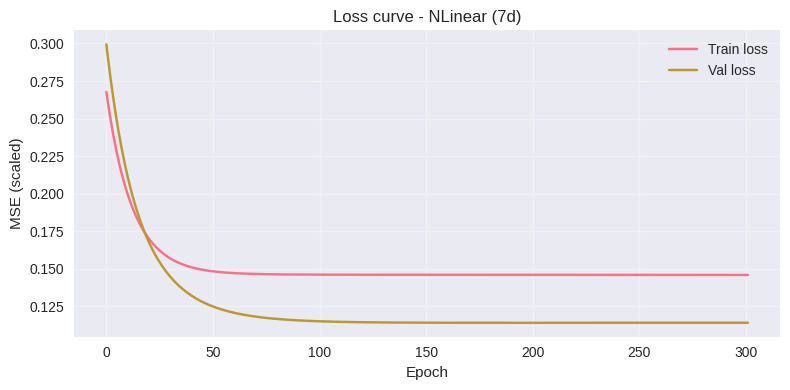

In [13]:
performance_rows = []
for model_name, horizons in results.items():
    for horizon, metrics in horizons.items():
        performance_rows.append({
            'Model': model_name,
            'Horizon': horizon,
            'Seq_Len': seq_lengths[horizon],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae'],
            'MSE': metrics['mse'],
            'R2': metrics['r2'],
            'Epochs': metrics['history']['epochs_ran']
        })
performance_df = pd.DataFrame(performance_rows).sort_values('RMSE').reset_index(drop=True)
print("\nBảng hiệu năng (sắp theo RMSE):")
display(performance_df)

best_row = performance_df.iloc[0]
best_model_name = best_row['Model']
best_horizon = best_row['Horizon']
print(f"\nBest combo: {best_model_name} với input {best_horizon} (seq_len={seq_lengths[best_horizon]})")
best_history = results[best_model_name][best_horizon]['history']

plt.figure(figsize=(8, 4))
plt.plot(best_history['train'], label='Train loss')
plt.plot(best_history['val'], label='Val loss')
plt.title(f"Loss curve - {best_model_name} ({best_horizon})")
plt.xlabel('Epoch')
plt.ylabel('MSE (scaled)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Huấn luyện lại và xuất dự báo cho toàn bộ mô hình

In [14]:
print("Huấn luyện lại 90% dữ liệu và xuất dự báo cho mọi model-horizon...")
os.makedirs('submissions', exist_ok=True)

def forecast_future(model, series_scaled, seq_len, scaler, device='cpu'):
    model.eval()
    last_seq = torch.from_numpy(series_scaled[-seq_len:].astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_scaled = model(last_seq).squeeze(0).cpu().numpy()
    pred_log = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    return np.exp(pred_log)

final_models = {name: {} for name in model_factories.keys()}
forecast_exports = []

for horizon, seq_len in seq_lengths.items():
    dataset = datasets[horizon]
    full_len = len(dataset)
    if full_len < 2:
        print(f"Bỏ qua {horizon} vì không đủ mẫu ({full_len}).")
        continue

    full_train_len = max(1, int(full_len * 0.9))
    train_subset = torch.utils.data.Subset(dataset, list(range(0, full_train_len)))
    val_subset = torch.utils.data.Subset(dataset, list(range(full_train_len, full_len)))
    train_loader = make_loader(train_subset, batch_size, shuffle=True)
    val_loader = make_loader(val_subset, batch_size, shuffle=False)

    for model_name, ModelClass in model_factories.items():
        print(f"Retraining {model_name} - {horizon}...", end=' ')
        model = ModelClass(seq_len, pred_len)
        retrained_model, retrain_history = train_model(
            model, train_loader, val_loader, num_epochs, learning_rate, patience, device
        )
        retrain_history['epochs_ran'] = len(retrain_history['train'])
        final_models[model_name][horizon] = retrained_model

        future_prices = forecast_future(retrained_model, series_scaled, seq_len, log_scaler, device)
        forecast_df = pd.DataFrame({'id': np.arange(1, pred_len + 1), 'close': future_prices})
        filename = f"submission_{model_name.lower()}_{horizon}_100d.csv"
        filepath = os.path.join('submissions', filename)
        forecast_df.to_csv(filepath, index=False)
        forecast_exports.append({
            'Model': model_name,
            'Horizon': horizon,
            'Seq_Len': seq_len,
            'ForecastFile': filepath,
            'RMSE_test': results[model_name][horizon]['rmse'],
            'Retrain_epochs': retrain_history['epochs_ran']
        })
        print(f"xong ({filepath})")

forecast_export_df = pd.DataFrame(forecast_exports).sort_values(['Model', 'Horizon']).reset_index(drop=True)
print("\nDanh sách file dự báo đã xuất:")
display(forecast_export_df)

best_forecast_path = forecast_export_df[
    (forecast_export_df['Model'] == best_model_name) &
    (forecast_export_df['Horizon'] == best_horizon)
]['ForecastFile'].iloc[0]
best_forecast_df = pd.read_csv(best_forecast_path)
future_prices = best_forecast_df['close'].values
submission_path = best_forecast_path
print(f"\nFile submission tương ứng combo tốt nhất: {submission_path}")

Huấn luyện lại 90% dữ liệu và xuất dự báo cho mọi model-horizon...
Retraining Linear - 7d... Early stopping tại epoch 290 (val loss: 0.038728)
xong (submissions/submission_linear_7d_100d.csv)
Retraining DLinear - 7d... Early stopping tại epoch 251 (val loss: 0.039391)
xong (submissions/submission_dlinear_7d_100d.csv)
Retraining NLinear - 7d... Early stopping tại epoch 146 (val loss: 0.040270)
xong (submissions/submission_nlinear_7d_100d.csv)
Retraining Linear - 30d... Early stopping tại epoch 279 (val loss: 0.030947)
xong (submissions/submission_linear_30d_100d.csv)
Retraining DLinear - 30d... Early stopping tại epoch 160 (val loss: 0.050767)
xong (submissions/submission_dlinear_30d_100d.csv)
Retraining NLinear - 30d... Early stopping tại epoch 141 (val loss: 0.048366)
xong (submissions/submission_nlinear_30d_100d.csv)
Retraining Linear - 120d... Early stopping tại epoch 220 (val loss: 0.050584)
xong (submissions/submission_linear_120d_100d.csv)
Retraining DLinear - 120d... Early stopp

,Model,Horizon,Seq_Len,ForecastFile,RMSE_test,Retrain_epochs
0,DLinear,120d,120,submissions/submission_dlinear_120d_100d.csv,24.189782,132
1,DLinear,30d,30,submissions/submission_dlinear_30d_100d.csv,26.667142,160
2,DLinear,480d,480,submissions/submission_dlinear_480d_100d.csv,58.090174,493
3,DLinear,7d,7,submissions/submission_dlinear_7d_100d.csv,25.306873,251
4,Linear,120d,120,submissions/submission_linear_120d_100d.csv,21.299812,220
5,Linear,30d,30,submissions/submission_linear_30d_100d.csv,26.830825,279
6,Linear,480d,480,submissions/submission_linear_480d_100d.csv,61.032184,607
7,Linear,7d,7,submissions/submission_linear_7d_100d.csv,25.522242,290
8,NLinear,120d,120,submissions/submission_nlinear_120d_100d.csv,10.564805,158
9,NLinear,30d,30,submissions/submission_nlinear_30d_100d.csv,9.764687,141



File submission tương ứng combo tốt nhất: submissions/submission_nlinear_7d_100d.csv


## 7. Đối chiếu dự báo vs thực tế trên tập test

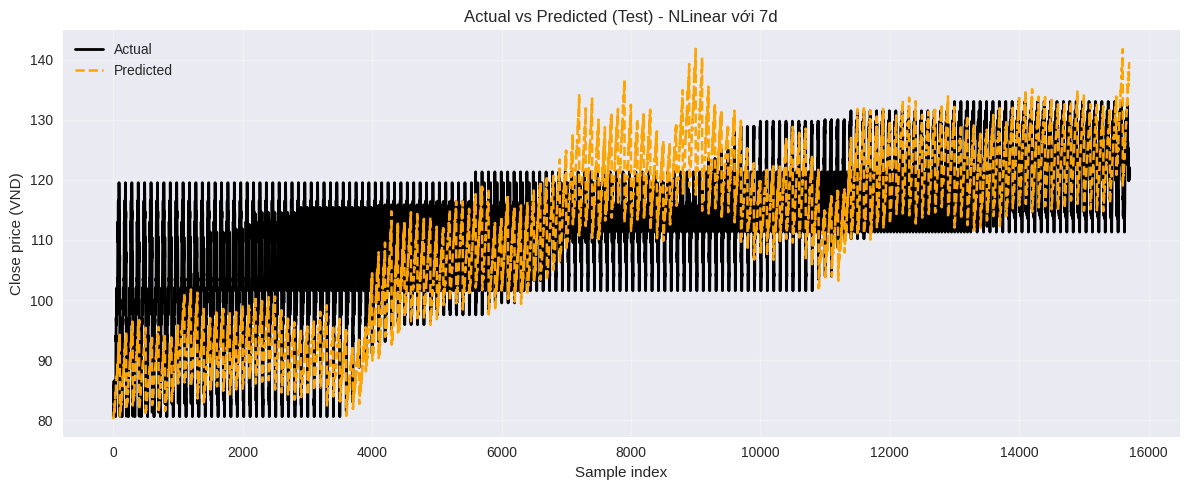

RMSE: 9.4604 | MAE: 7.1968 | Trung bình chênh lệch: 7.1968


In [15]:
best_metrics = results[best_model_name][best_horizon]
actual_sequences = best_metrics['actual_sequences_price']
pred_sequences = best_metrics['pred_sequences_price']

if actual_sequences.size == 0:
    print("Không có dữ liệu test để vẽ.")
else:
    actual_flat = actual_sequences.flatten()
    pred_flat = pred_sequences.flatten()
    plt.figure(figsize=(12, 5))
    plt.plot(actual_flat, label='Actual', color='black', linewidth=2)
    plt.plot(pred_flat, label='Predicted', color='orange', linewidth=1.8, linestyle='--')
    plt.title(f"Actual vs Predicted (Test) - {best_model_name} với {best_horizon}")
    plt.xlabel('Sample index')
    plt.ylabel('Close price (VND)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    diff = np.abs(actual_flat - pred_flat)
    print(f"RMSE: {best_metrics['rmse']:.4f} | MAE: {best_metrics['mae']:.4f} | Trung bình chênh lệch: {diff.mean():.4f}")

## 8. Dự báo 100 ngày tiếp theo & xuất submission

In [16]:
print(f"Sử dụng combo tốt nhất: {best_model_name} với {best_horizon} (seq_len={seq_lengths[best_horizon]})")
print(f"File submission được chọn: {submission_path}")

forecast_df = best_forecast_df.copy()
display(forecast_df.head())

Sử dụng combo tốt nhất: NLinear với 7d (seq_len=7)
File submission được chọn: submissions/submission_nlinear_7d_100d.csv


,id,close
0,1,120.566500
1,2,120.268380
2,3,120.698456
3,4,120.504150
4,5,121.514854


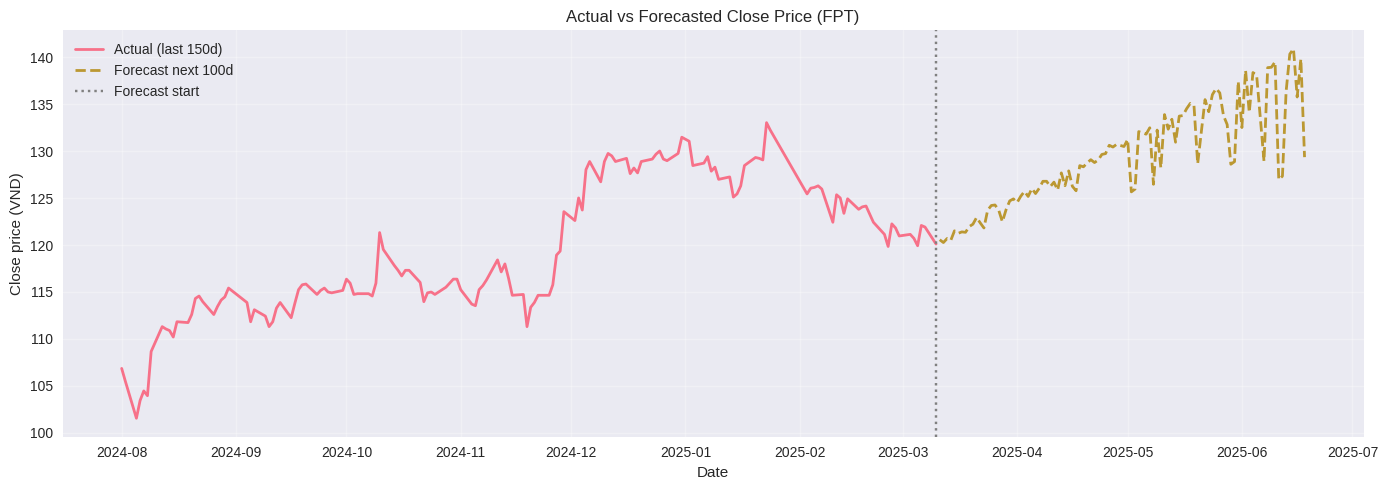

In [17]:
history_window = 150
history_data = df.tail(history_window)
future_start = history_data['time'].iloc[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(future_start, periods=pred_len, freq='D')

plt.figure(figsize=(14, 5))
plt.plot(history_data['time'], history_data['close'], label='Actual (last 150d)', linewidth=2)
plt.plot(future_dates, future_prices, label='Forecast next 100d', linewidth=2, linestyle='--')
plt.axvline(history_data['time'].iloc[-1], color='gray', linestyle=':', label='Forecast start')
plt.title('Actual vs Forecasted Close Price (FPT)')
plt.xlabel('Date')
plt.ylabel('Close price (VND)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
submission_check = pd.read_csv(submission_path)
print(f"Submission rows (bao gồm header): {len(submission_check) + 1}")
print(submission_check.head())
print(submission_check.tail())

Submission rows (bao gồm header): 101
   id       close
0   1  120.566500
1   2  120.268380
2   3  120.698456
3   4  120.504150
4   5  121.514854
     id      close
95   96  140.34534
96   97  140.90834
97   98  135.77347
98   99  139.82626
99  100  129.36644


In [19]:
performance_export_path = 'submissions/fpt_ltsf_performance.csv'
performance_df.to_csv(performance_export_path, index=False)

comparison_export_path = 'submissions/fpt_forecast_manifest.csv'
forecast_export_df.to_csv(comparison_export_path, index=False)

print(f"Đã lưu bảng hiệu năng tại {performance_export_path}")
print(f"Đã lưu manifest forecast tại {comparison_export_path}")
print(f"Combo tốt nhất: {best_model_name} với {best_horizon}, file submission: {submission_path}")

Đã lưu bảng hiệu năng tại submissions/fpt_ltsf_performance.csv
Đã lưu manifest forecast tại submissions/fpt_forecast_manifest.csv
Combo tốt nhất: NLinear với 7d, file submission: submissions/submission_nlinear_7d_100d.csv
